In [1]:
cellpose_seg0 = r"output\test\2D_patch_test_0_seg.npy"
cellpose_seg1 = r"output\test\2D_patch_test_1_seg.npy"


In [78]:
import numpy as np
from cellpose import plot, utils, io, models
import matplotlib.pyplot as plt
from skimage.draw import polygon

# Load the segmentation mask
dat_0 = np.load(cellpose_seg0, allow_pickle=True).item()
# Extract the masks and generate outlines
masks_0 = dat_0['masks']
outlines_0 = utils.outlines_list(masks_0) # multiprocessing_threshold=1000



Multiprocessing is disabled for Windows


In [79]:
# Create a blank binary image to fill in the cells
filled_image_0 = np.zeros_like(masks_0, dtype=np.uint8)  # Start with black (0)

# Fill each outline's interior as white
for outline in outlines_0:
    # Ensure the outline coordinates are in integer format
    outline = np.array(outline, dtype=np.int32)
    
    # Get the rows and columns for the interior of each polygon
    rr, cc = polygon(outline[:, 1], outline[:, 0], filled_image_0.shape)
    filled_image_0[rr, cc] = 255  # Fill with white (255) inside each contour

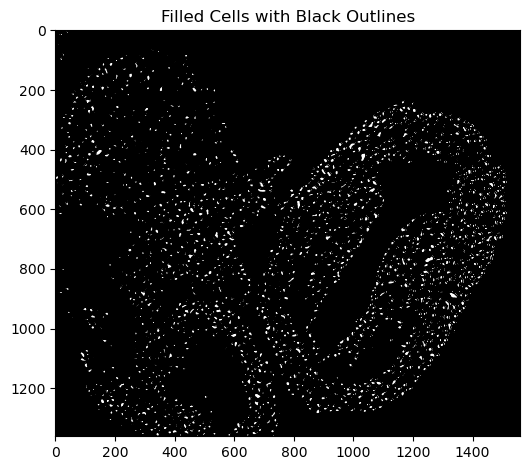

In [80]:
# Plot the filled binary image with black outlines
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(filled_image_0, cmap='gray', interpolation='none')
for outline in outlines_0:
    plt.plot(outline[:, 0], outline[:, 1], color='black', linewidth   =1)  # Add black outlines on top

ax.set_title("Filled Cells with Black Outlines")
ax.axis('on')
plt.show()

In [81]:
# Load the segmentation mask
dat_1 = np.load(cellpose_seg1, allow_pickle=True).item()
# Extract the masks and generate outlines
masks_1 = dat_1['masks']
outlines_1 = utils.outlines_list(masks_1) # multiprocessing_threshold=1000

Multiprocessing is disabled for Windows


In [82]:
# Create a blank binary image to fill in the cells
filled_image_1 = np.zeros_like(masks_1, dtype=np.uint8)  # Start with black (0)

# Fill each outline's interior as white
for outline in outlines_1:
    # Ensure the outline coordinates are in integer format
    outline = np.array(outline, dtype=np.int32)
    
    # Get the rows and columns for the interior of each polygon
    rr, cc = polygon(outline[:, 1], outline[:, 0], filled_image_1.shape)
    filled_image_1[rr, cc] = 255  # Fill with white (255) inside each contour

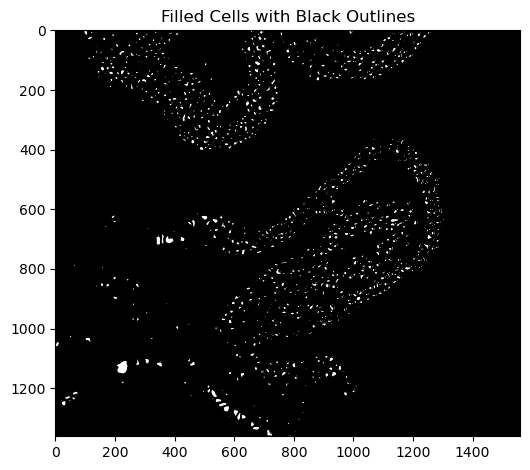

In [83]:
# Plot the filled binary image with black outlines
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(filled_image_1, cmap='gray', interpolation='none')
for outline in outlines_1:
    plt.plot(outline[:, 0], outline[:, 1], color='black', linewidth=1)  # Add black outlines on top

ax.set_title("Filled Cells with Black Outlines")
ax.axis('on')
plt.show()

In [94]:
# Define the shape of the new mask
mask_shape = (2478, 1560)

# Create a zero-filled mask
filled_image_new = np.zeros(mask_shape, dtype=np.uint8) 

# Define adjusted main segment coordinates
segments = [
    (0, 1362, 0, 1560),   # Segment 0
    (1116, 2478, 0, 1560) # Segment 1
]

# Offsets for each segment
offsets = [
    (0, 0),               # No offset for Segment 0
    (1116, 0)             # Offset for Segment 1 (row offset, column offset)
]

# New outline list
new_outlines = []

# Fill each outline's interior as white
for outline in outlines_0:
    # Add [1116, 0] to each coordinate in the outline
    outline = np.array(outline, dtype=np.int32) + np.array([0, 0], dtype=np.int32)
    new_outlines.append(outline)

    # Get the rows and columns for the interior of each polygon
    rr, cc = polygon(outline[:, 1], outline[:, 0], filled_image_new.shape)
    filled_image_new[rr, cc] = 155  # Fill with white (255) inside each contour

# Fill each outline's interior as white
for outline in outlines_1:
    # Add [1116, 0] to each coordinate in the outline
    outline = np.array(outline, dtype=np.int32) + np.array([0, 1116], dtype=np.int32)
    new_outlines.append(outline)
    
    # Get the rows and columns for the interior of each polygon
    rr, cc = polygon(outline[:, 1], outline[:, 0], filled_image_new.shape)
    filled_image_new[rr, cc] = 255  # Fill with white (255) inside each contour

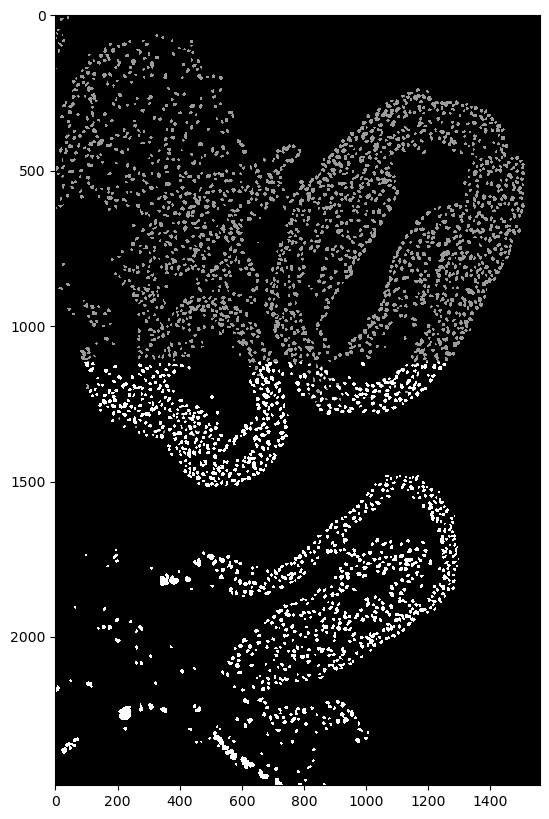

In [95]:
# Plot the filled binary image with black outlines
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(filled_image_new, cmap='gray', interpolation='none')

In [93]:
import pandas as pd

def boundaries_to_table(boundaries):
    # Create an empty list to store data rows
    data = []
    
    # Loop through each boundary (each cell)
    for cell_id, boundary in enumerate(boundaries, start=1):
        # Loop through each point in the boundary
        for point in boundary:
            # Append cell_id, x, y to the data list
            data.append([cell_id, point[0], point[1]])
    
    # Create a DataFrame with the data
    df = pd.DataFrame(data, columns=['cell_id', 'vertex_x', 'vertex_y'])
    
    return df

In [96]:
# Convert boundaries to table
df_outlines_list = boundaries_to_table(new_outlines)
df_outlines_list

,cell_id,vertex_x,vertex_y
0,1,40,3
1,1,39,4
2,1,38,5
3,1,37,6
4,1,37,7
...,...,...,...
103470,3122,869,2475
103471,3122,868,2474
103472,3122,867,2473
103473,3122,866,2472


In [97]:
def reduce_points(df):
    # Group by cell_id and get counts
    cell_counts = df.groupby('cell_id').size()
    
    new_df = pd.DataFrame()
    
    for cell_id in cell_counts.index:
        cell_data = df[df['cell_id'] == cell_id]
        
        if cell_counts[cell_id] > 50:
            # Keep every other row until we have 50 points
            reduced_data = cell_data.iloc[::2].head(50)
        elif 30 < cell_counts[cell_id] <= 50:
            # Keep every other row until we have 30 points
            reduced_data = cell_data.iloc[::2].head(30)
        else:
            # Keep all points if count <= 30
            reduced_data = cell_data
            
        new_df = pd.concat([new_df, reduced_data])
    
    return new_df.reset_index(drop=True)

In [98]:
# Apply the function
reduced_outlines_list = reduce_points(df_outlines_list)

# Print the results
print("Original shape:", df_outlines_list.shape)
print("Reduced shape:", reduced_outlines_list.shape)


Original shape: (103475, 3)
Reduced shape: (69069, 3)


In [99]:
unique_cell_count = reduced_outlines_list['cell_id'].nunique()
# unique_cell_count = boundary_df['cell_id'].nunique()

unique_cell_count

3122

In [100]:

def calculate_centroids(df):
    # Group the DataFrame by 'cell_id'
    grouped = df.groupby('cell_id')
    
    # Calculate centroids for each group
    centroids = grouped[['vertex_x', 'vertex_y']].mean().reset_index()
    
    # Rename columns if needed to indicate centroids explicitly
    centroids.rename(columns={'vertex_x': 'centroid_x', 'vertex_y': 'centroid_y'}, inplace=True)
    
    return centroids


In [101]:
# Calculate centroids for each cell
centroids_df = calculate_centroids(reduced_outlines_list)
centroids_df

,cell_id,centroid_x,centroid_y
0,1,41.333333,7.250000
1,2,21.035714,12.857143
2,3,10.000000,47.000000
3,4,5.000000,58.545455
4,5,327.480000,65.640000
...,...,...,...
3117,3118,673.441176,2450.323529
3118,3119,717.923077,2467.897436
3119,3120,805.090909,2462.000000
3120,3121,788.312500,2474.187500
